# PART 5

previous session we built multi-layer perceptron with the following architecture

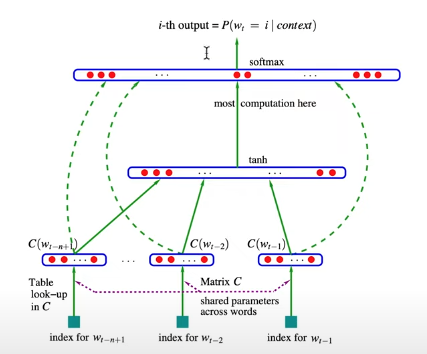

this session we want to complexify the architecture to achieve
- more words for context, not just 3
- instead of squashing all context into 1 layer, make more layers for deeper network, and gradually learned/build the relation between words

as we make the architecture more complext, this will look like a **wavenet**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all names
words = open('names.txt', 'r').read().splitlines()
print('first 10 words:\n')
print(words[:10])
print('\nlen of words: ', len(words))

first 10 words:

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

len of words:  32033


In [3]:
# build vocab
chars = sorted(
    list( set(''.join(words) ) )
)
stoi = {s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items() }
print(itos)

vocab_size = len(itos)
print('vocab size: ', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab size:  27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 3

def build_dataset(words):
    
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [6]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        # forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [36]:
torch.manual_seed(42)

n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [34]:
def train(max_steps, batch_size, lossi, layers, parameters ):
    
    for i in range(max_steps):
        # mini batch indices
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        # forward pass
        emb = C[Xb] # [32, 3, 2]
        x = emb.view(emb.shape[0], -1) # embedding concat based on context size
    
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)
    
        # backward pass
        for p in parameters:
            # reset gradient
            p.grad = None
        loss.backward()
        
        # update: simple SGD
        lr = 0.1 if i < max_steps / 2 else 0.01 # learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        # lri.append(lre[i])
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

In [37]:
# training
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, layers, parameters)


      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7087
 120000/ 200000: 2.3243
 130000/ 200000: 2.2512
 140000/ 200000: 2.0113
 150000/ 200000: 1.8195
 160000/ 200000: 1.7985
 170000/ 200000: 2.2206
 180000/ 200000: 2.0566
 190000/ 200000: 2.1030


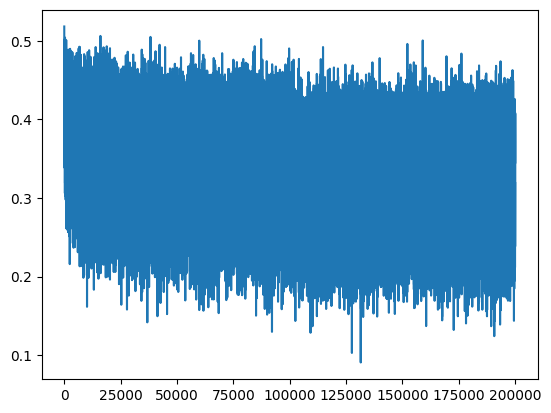

In [38]:
# loss is noisy (thick) because batch size is too small,
# we could get really lucky, or unluck depending on batch
plt.plot(lossi)

In [14]:
# put layers in eval mode, for batchNorm especially
for layer in layers:
    layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    logits = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0621414184570312
val 2.109346389770508


In [16]:
# sample from the model to generate 20 names
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        x = emb.view(emb.shape[0], -1) # concat the vector (3 words)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the sample returns special token '.', stop
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

damiara.
alyzah.
faraliza.
francy.
roy.
lorie.
rossot.
emon.
catine.
aub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.


In [17]:
lossi[:10]

[0.5180676579475403,
 0.5164594054222107,
 0.507362961769104,
 0.507546603679657,
 0.4992470443248749,
 0.5014019012451172,
 0.5049523115158081,
 0.48866209387779236,
 0.4999050199985504,
 0.4899313449859619]

In [21]:
torch.arange(10).view(5,2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [24]:
# or use -1 to auto calculate the other dim
torch.arange(10).view(5,-1)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

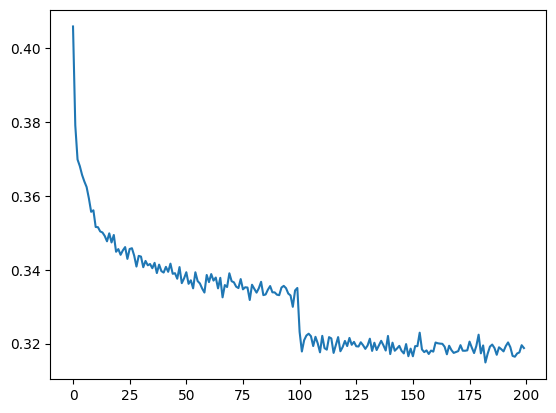

In [39]:
# now we can re-arrange our loss, to be rows of 1000, and take the avg of each row, then plot that
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

we see that the `learning rate` decay hit at step 100*1000

next thing we want to update, the `forward pass` code should also be abstracted as layers to simplify:
```
# forward pass
emb = C[Xb] # [32, 3, 2] # embedding look up based on batch Xb, extract to `Embedding` layer
x = emb.view(emb.shape[0], -1) # embedding concat based on context size, extract to `Concat` layer
```

In [30]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

In [31]:
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [49]:
# introduce the concept of model containers to organize layers.
# for our case we can say Sequential model
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x);
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [50]:
# construct the new layers
n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [51]:
# update train with the new layers in consideration
# we no longer need C, it will be part of layers
def train(max_steps, batch_size, lossi, layers, parameters ):
    
    for i in range(max_steps):
        # mini batch indices
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        # forward pass
        logits = model(Xb) # use model
        loss = F.cross_entropy(logits, Yb)
    
        # backward pass
        for p in parameters:
            # reset gradient
            p.grad = None
        loss.backward()
        
        # update: simple SGD
        lr = 0.1 if i < max_steps / 2 else 0.01 # learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        # lri.append(lre[i])
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

In [52]:
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, layers, parameters)

      0/ 200000: 3.5237
  10000/ 200000: 2.8331
  20000/ 200000: 2.6207
  30000/ 200000: 2.1111
  40000/ 200000: 2.7413
  50000/ 200000: 2.4758
  60000/ 200000: 2.2578
  70000/ 200000: 2.4570
  80000/ 200000: 2.1220
  90000/ 200000: 2.1006
 100000/ 200000: 2.1924
 110000/ 200000: 2.0145
 120000/ 200000: 2.2810
 130000/ 200000: 2.1111
 140000/ 200000: 2.1851
 150000/ 200000: 2.1289
 160000/ 200000: 1.8578
 170000/ 200000: 2.4214
 180000/ 200000: 2.0222
 190000/ 200000: 2.2351


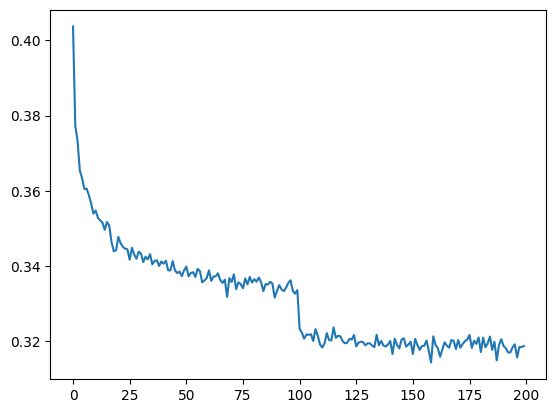

In [53]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [54]:
# now calculate overall loss like b4, 1st turn off training mode
for layer in model.layers:
    layer.training = False

In [55]:
# loss evaluaiton simplifies
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.063701629638672
val 2.108781337738037


In [56]:
# sampling also simplifies
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the sample returns special token '.', stop
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

kiyah.
jehieren.
ebroyen.
dajourkatin.
valea.
boddyn.
dekirn.
landerky.
chy.
alishodi.
sahelinaxynne.
lylanee.
ziloliny.
maymondellia.
jtonesmael.
williearlee.
jaia.
adhiomasseuneblla.
poln.
zhaviell.


notice that the train/val loss are very similar
```
train 2.063701629638672
val 2.108781337738037
```

this means we are not _overfitting_ the model, otherwise training loss << validation loss.

this means we can scale our model with more layers to get better result.

our current model concat multiple characters into one layer in 1 step

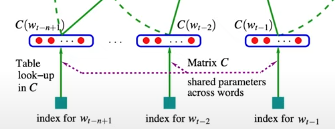

and then neural net will learn from that 1 layer.

we will achieve better result if we gradually concat/learned in hiearchical manner, like the following

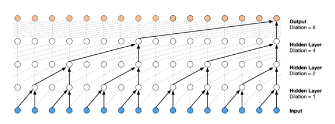

the bottom blue dots are inputs
- next hidden layer only learns from bigram pair of previous
- keep collapsing as we go deeper
- output predict the next character from all the gradual collapsing of learning

In [57]:
# to do this pair wise collapsing, lets change how dataset is built,
# we need to change the block size to 8, divisible by 2
# this means context is 8 chars, to predict the 9th char
block_size = 8

def build_dataset(words):
    
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [58]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [59]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [60]:
# redefine the network
n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [61]:
# the network should just run
max_steps = 1
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, layers, parameters)

      0/      1: 3.5016


but it doesnt make sense because our context is 8 char long, we are crushing a lot of info into 1 layer

In [62]:
# but lets run it and see if it improves loss
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, layers, parameters)

      0/ 200000: 3.4691
  10000/ 200000: 2.5695
  20000/ 200000: 2.2908
  30000/ 200000: 1.9904
  40000/ 200000: 2.0194
  50000/ 200000: 2.0692
  60000/ 200000: 1.7469
  70000/ 200000: 2.7224
  80000/ 200000: 1.7093
  90000/ 200000: 1.9635
 100000/ 200000: 1.9783
 110000/ 200000: 2.3890
 120000/ 200000: 1.9754
 130000/ 200000: 2.0893
 140000/ 200000: 2.1742
 150000/ 200000: 1.9445
 160000/ 200000: 1.5422
 170000/ 200000: 1.8399
 180000/ 200000: 1.8225
 190000/ 200000: 2.0206


In [63]:
# check the overall loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9306753873825073
val 2.025573253631592


validation loss is improved as well, just by increasing context size.

this proves that there are a lot of room left for simple tuning.

let s now explore how to implement the hierarchal network architecture.

In [64]:
# lets only look at 4 examples, each of context size 8 (block_size)
ix = torch.randint(0, Xtr.shape[0], (4,)) # randomly pick 4 indices out of training size
Xb, Yb = Xtr[ix], Ytr[ix] # make a batch of 4
logits = model(Xb) # get the model output for the batch
print(Xb.shape) # shape of the batch
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  3,  1, 18, 12,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1, 19,  8],
        [ 0,  0,  0,  0, 19,  8,  9, 25]])